In [1]:
# imports

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [2]:
# config

config = {
    'seed': 12345
}

In [3]:
# load data

df = pd.read_csv('data/reviews_simple_preprocessed.csv')

df['rating_total'] = df['rating_total'].fillna(0)
df['rating_total'] = df['rating_total'].astype(int)

In [4]:
# transform data

df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df[['rating_total']]

In [5]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config['seed'])

In [6]:
# train model

tuning_grid = dict(
    kernel = ['linear', 'rbf', 'sigmoid', 'poly'],
    C = range(1, 11, 1),
    degree = range(11),
    gamma = ['scale', 'auto']
)

tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=config['seed'])
gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=config['seed'], 
    cv=tuning_cv, scoring="accuracy", verbose=1)
searchResults = gridSearch.fit(X_train, y_train)
model_total = searchResults.best_estimator_
print('The best model foor item: ' + str(model_total))

Fitting 15 folds for each of 50 candidates, totalling 750 fits


/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

The best model foor item: SVC(C=3, degree=10)


In [7]:
# test model

y_predicted = model_total.predict(X_test)

Accuracy:  {'rating_total': 0.75}


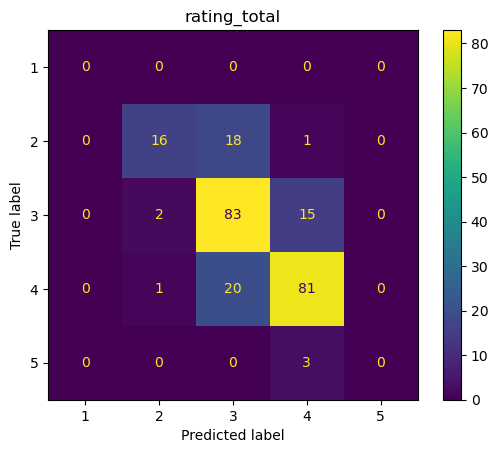

In [9]:
# show results

accuracy = {}

cm = confusion_matrix(y_test, y_predicted, labels=model_total.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_total.classes_)
disp.plot()
plt.title('rating_total')
accuracy['rating_total'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)

plt.show()

In [184]:
with open('model/svm_total.pkl', 'wb') as f:
    clf = pickle.dump(model_total, f)